"NBA Player Clustering" - Michael Wu


## Introduction

Throughout the history of the NBA and basketball, there have been five positions: pg, sg, sf, pf, and center. A lot has changed during the past few years. Players are adopting new and different styles of plays, transcending their predefined roles. For example, centers, who traditionally spend most of their time in the paint, protecting the rim, and dunking on people, are now making plays away from the basket and moving towards mid range shots and even three-pointers. The dynamic evolution of basketball requires a more accurate and robust categorization of players. This may help teams better understand their lineups, and know which type of players they are missing or have an overabundance of. Knowledge like this can help teams make more informed decisions in building a strong team. 

## How are we going to do it?

In this analysis, we are going to use the K-means clustering algorithm to categorize NBA players into distinct groups based on their playstyles and on-court tendencies. K-means is an unsupervised machine learning technique that partitions data points into clusters, where each cluster represents a group of players with similar characteristics.

We begin by selecting a predefined number of clusters (K). The algorithm then iteratively assigns each player to the cluster whose centroid (representative point) is closest to their statistical profile. This proximity is determined using a distance metric, often Euclidean distance. The centroids are re-calculated based on the players assigned to each cluster in each iteration, optimizing cluster separation. The process continues until convergence is achieved.

K-means provides a data-driven approach to player categorization, allowing us to uncover patterns in player performance beyond traditional positional boundaries. By identifying inherent similarities and differences among players, we aim to reveal meaningful insights into the evolving landscape of NBA basketball.

## Features

- Points
- Assists
- Rebounds
- Steals
- Blocks
- % of 2-point goals assisted
- % of 3-point goals assisted
- % of goals made close to the basket (denoted as layup %)
- % of goals made as mid-range shots
- % of goals made as  three-pointers

$*$ all statistics are in per 36 mins of play to adjust for playing time differences
Above are the features which we will use in K-means clustering. Each statistic provides vital insights into the player's unique style and role on the court. For instance, a player with high rebound and block numbers may be classified as a dominant big man. Conversely, a player with a lower points-to-assists ratio may typify a pass-first point guard, prioritizing setting up teammates over scoring. Another player with high three-point field goal attempts, steals, and blocks could fit the profile of a 'three-and-D' player, renowned for their perimeter shooting and defensive contributions. Moreover, there may be combinations of stat lines that reveal entirely novel player archetypes, ones yet to be categorized or named.

## Data Processing 

In this analysis, we are only going to use players who have played more than 25 games and at least 12 minutes a game, because it is hard to determine the playstyle of an individual when they barely play or when they only play “garbage” minutes.

For the statistic, % of goals that are three-pointers, a number of plays are missing this stat because they have never shot a three-pointer throughtout the season. In our case, they are all centers. We replaced the NA values for those players with the median, which is 1. 

Players who played on multiple teams during the season, have multiple rows. One represents their average stats across teams, and the others detail team-specific stats. We are going to use the former, since a player’s style of play usually does not change drastically when they play on different teams. 

All features are scaled or standardized to have a mean of 0 and 1. Scaling does not change the fundamental information contained in the data, or the relationship between data points. It ensures that variables with larger units are not given higher importance solely due to their measurement scales.

In [1]:
knitr::opts_chunk$set(echo = TRUE)

require(devtools)
install_version("pbkrtest", version = "0.4.5", repos = "http://cran.us.r-project.org")
install.packages("factoextra")
install.packages("car")
install.packages("tidyverse")
install.packages("gtExtras")

library(dplyr)
library(readr)
library(tidyr)
library(ggplot2)
library(factoextra)
library(reshape2)
library(tidyverse)
library(gt)
library(gtExtras)

# setting up the data

per_36_raw <- read_csv("Sheet 4-Per-36.csv")
shooting_raw <- read_csv("Sheet 5-Shooting.csv")
advanced_raw <- read_csv("Sheet 3-Advanced.csv")

per_36 <- per_36_raw %>%
  distinct(Player, .keep_all = TRUE) %>%
  filter(G >= 25 & MP >= 12)

shooting <- shooting_raw %>%
  distinct(Player, .keep_all = TRUE) %>%
  filter(G >= 25 & MP >= 12) %>%
  mutate(layup_pct = zero_three_fga + three_ten_fga, midrange_pct = ten_sixteen_fga + sixteen_three_fga)

advanced <- advanced_raw %>%
  distinct(Player, .keep_all = TRUE)

# joining multiple tables and renaming column names

join_1 <- left_join(per_36, shooting, by = "Player")
final <- left_join(join_1, advanced, by = "Player")

# There is a feature called three_assisted, which denotes the percentage of threes made that were assisted. Some players,
# which are all players who play at the Center position in our case, have never taken a three in the season, which results in
# the NA values in the three_assisted column. When we take a look at the distribution of the percentage of threes made that were
# assisted across Centers, it is very right-skewed, which means most of their threes were assisted. 

center <- shooting[shooting$Pos == "C",]
center <- center[!(is.na(center$three_pointer_assisted)), ]
center_assisted_three <- median(center$three_pointer_assisted)

# Replacing NA values with the median, which is 1.

final$three_pointer_assisted <- replace(final$three_pointer_assisted, is.na(final$three_pointer_assisted), 1)

# Selecting the features and put it in dataset

player_stats <- final %>%
  select(name = Player, position = Pos.x, per = PER, tsp = TSP,ftr = FTr, usgr = USGr,
         corner_3pa_r = corner_3PA_r, three_accuracy = three_accuracy, 
         points = PTS, layup_pct = layup_pct, assists = AST, rebounds = TRB, steals = STL, blocks = BLK,
         two_assisted = two_pointer_assisted, three_assisted = three_pointer_assisted, 
         midrange_pct = midrange_pct, threepointer_pct = three_pointer_fga
         ) %>%
  mutate(points_scaled = sqrt(points))


Loading required package: devtools

Loading required package: usethis




Installing package into ‘/opt/r’
(as ‘lib’ is unspecified)

Installing package into ‘/opt/r’
(as ‘lib’ is unspecified)

Installing package into ‘/opt/r’
(as ‘lib’ is unspecified)

Installing package into ‘/opt/r’
(as ‘lib’ is unspecified)

Installing package into ‘/opt/r’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dply


## Correlation Plot

In the correlation heatmap, we see that % of field goals made close to the rim is negatively correlated with % of field goals made from the three-point line. This should be self-explanatory because if a person scores more in the paint, their numbers outside the paint will obviously be relatively lower. We are going to get rid of % of field goals made close to the rim to reduce multicollinearity. Besides the relationship between the two variables mentioned, all other variables do not have significant correlations with each other, which reduces problems of interpretibility and redundancy.

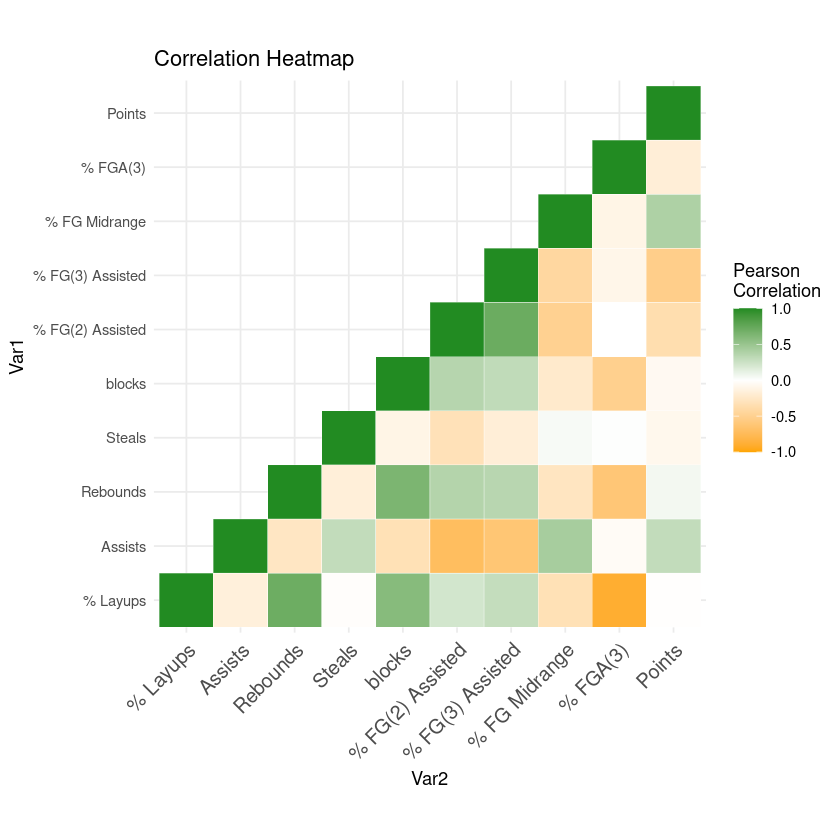

In [2]:
# scaling the features
player_stats_scaled <- scale(player_stats[11:19])

# Making a correlation heatmap

cormap <- player_stats[,10:19]
colnames(cormap) <- c("% Layups", "Assists", "Rebounds", "Steals", "blocks",
                      "% FG(2) Assisted", "% FG(3) Assisted", "% FG Midrange",
                      "% FGA(3)", "Points")

cormat <- round(cor(cormap),2)
melted_cormat <- melt(cormat)

get_upper_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
}

upper_tri <- get_upper_tri(cormat)

melted_cormat <- melt(upper_tri, na.rm = TRUE)

ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "orange", high = "forestgreen", mid = "white",
   midpoint = 0, limit = c(-1,1), space = "Lab",
   name="Pearson\nCorrelation") +
  theme_minimal()+
 theme(axis.text.x = element_text(angle = 45, vjust = 1,
    size = 12, hjust = 1))+
 coord_fixed() + ggtitle("Correlation Heatmap")

## Choosing Number of Clusters

To determine the right number of clusters, we initially applied the elbow method, a widely used technique to identify the point where the within-cluster sum of squares (WCSS) starts to level off. The number on the “elbow” appears to be 3. However, when we used that number for K-means, the results were unsatisfactory, with players with drastically different playstyles within the same cluster. As a response, we experimented with multiple cluster counts, and using domain knowledge, we decided on 8. Our goal was to strike a balance between creating granular clusters that capture nuanced player variations and avoiding over-segmentation that might lead to less interpretable results.


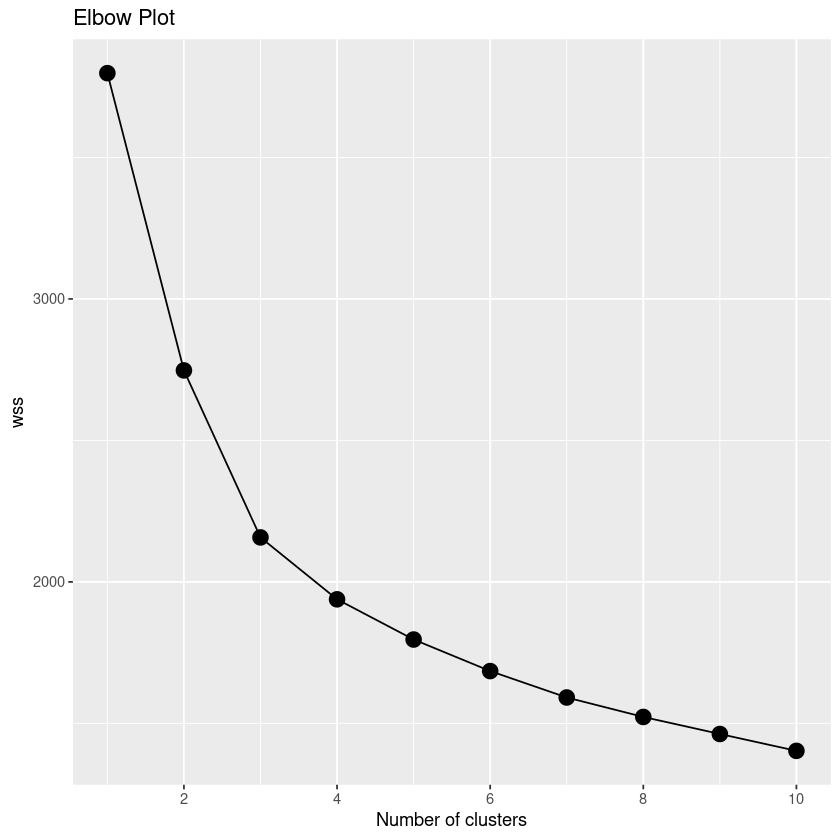

In [3]:
# Decide how many clusters to look at
n <- 10

# Initialize total within sum of squares error: wss
wss <- numeric(n)

set.seed(123)

# Look over 1 to n possible clusters
for (i in 1:n) {
  # Fit the model: km.out
  km.out <- kmeans(player_stats_scaled, centers = i, nstart = 20)
  # Save the within cluster sum of squares
  wss[i] <- km.out$tot.withinss
}

# Produce a scree plot
wss_df <- tibble(clusters = 1:n, wss = wss)
 
scree_plot <- ggplot(wss_df, aes(x = clusters, y = wss, group = 1)) +
    geom_point(size = 4)+
    geom_line() +
    scale_x_continuous(breaks = c(2, 4, 6, 8, 10, 12)) +
    xlab('Number of clusters') + ggtitle("Elbow Plot")
scree_plot

## Results

In [4]:
km.out <- kmeans(player_stats_scaled, centers = 7, nstart = 100)

player_stats$type <- km.out$cluster

player_types <- player_stats %>%
  mutate(pa_ratio = points/assists) %>%
  select(name = name, type = type, position = position, points, assists, pa_ratio, rebounds, steals, blocks,
         two_assisted, three_assisted, layup_pct, midrange_pct, threepointer_pct, per, tsp, usgr, ftr, three_accuracy,
         corner_3pa_r)

player_types$type <- as.character(player_types$type)

mean_data <- player_types %>%
  group_by(type) %>%
  summarize(
    mean_points = mean(points),
    mean_assists = mean(assists),
    mean_pa_ratio = mean(pa_ratio),
    mean_rebounds = mean(rebounds),
    mean_steals = mean(steals),
    mean_blocks = mean(blocks),
    mean_two_assisted = mean(two_assisted),
    mean_three_assisted = mean(three_assisted),
    mean_layup_pct = mean(layup_pct),
    mean_midrange_pct = mean(midrange_pct),
    mean_three_pct = mean(threepointer_pct),
    mean_three_accuracy = mean(three_accuracy),
    mean_per = mean(per),
    mean_tsp = mean(tsp),
    mean_usgr = mean(usgr),
    mean_ftr = mean(ftr),
    mean_corner_3pa_r = mean(corner_3pa_r)
  )

## results and averages across types
table1 <- mean_data %>%
  select(type, mean_points, mean_assists, mean_rebounds, mean_steals, mean_blocks, 
         mean_pa_ratio, mean_two_assisted, mean_three_pct, mean_usgr)

knitr::kable(table1, "pipe", col.name = c("Type", "Points", "Assists", "Rebounds",
                                         "Steals", "Blocks", "PA Ratio", "% FG(2) Assisted",
                                         "% FGA(3)", "Usage Rate"), caption = "Averages Across Types",
                                         digits = 2)





Table: Averages Across Types

|Type | Points| Assists| Rebounds| Steals| Blocks| PA Ratio| % FG(2) Assisted| % FGA(3)| Usage Rate|
|:----|------:|-------:|--------:|------:|------:|--------:|----------------:|--------:|----------:|
|1    |  23.92|    6.20|     5.54|   1.12|   0.44|     4.22|             0.30|     0.37|      27.95|
|2    |  13.41|    5.72|     4.04|   1.37|   0.38|     2.54|             0.32|     0.43|      17.69|
|3    |  17.46|    2.77|     9.51|   0.85|   0.93|     7.80|             0.65|     0.23|      19.61|
|4    |  12.47|    3.73|     6.43|   1.71|   0.69|     4.13|             0.57|     0.38|      15.50|
|5    |  17.10|    3.11|     4.75|   0.98|   0.40|     6.30|             0.52|     0.45|      20.45|
|6    |  12.40|    2.24|     5.44|   0.90|   0.52|     6.06|             0.70|     0.61|      14.52|
|7    |  14.41|    1.90|    11.49|   0.92|   2.14|     9.20|             0.69|     0.09|      15.87|

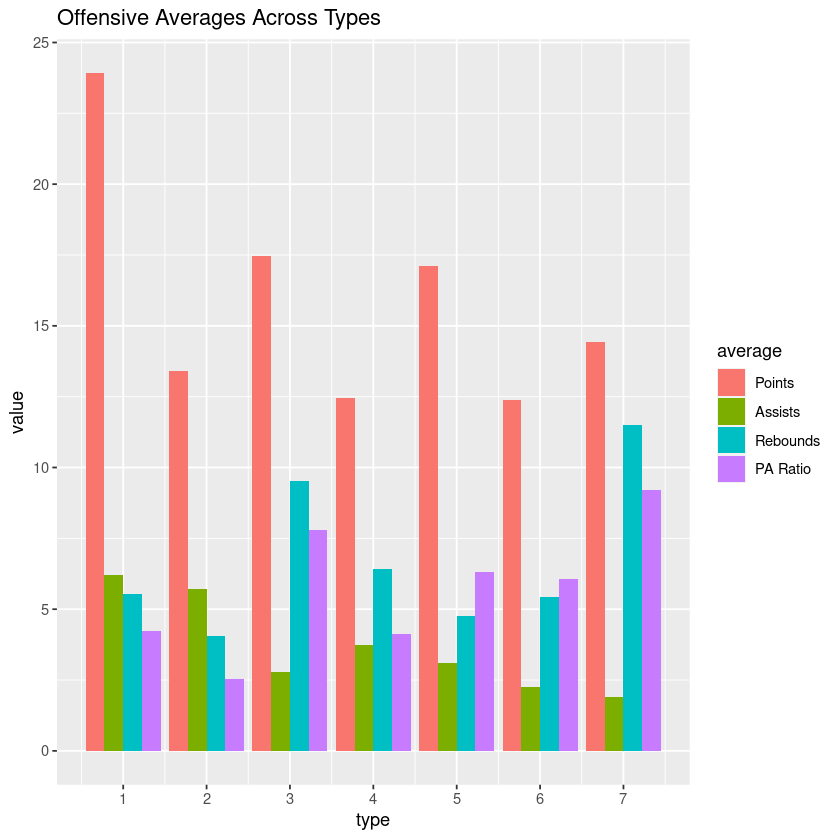

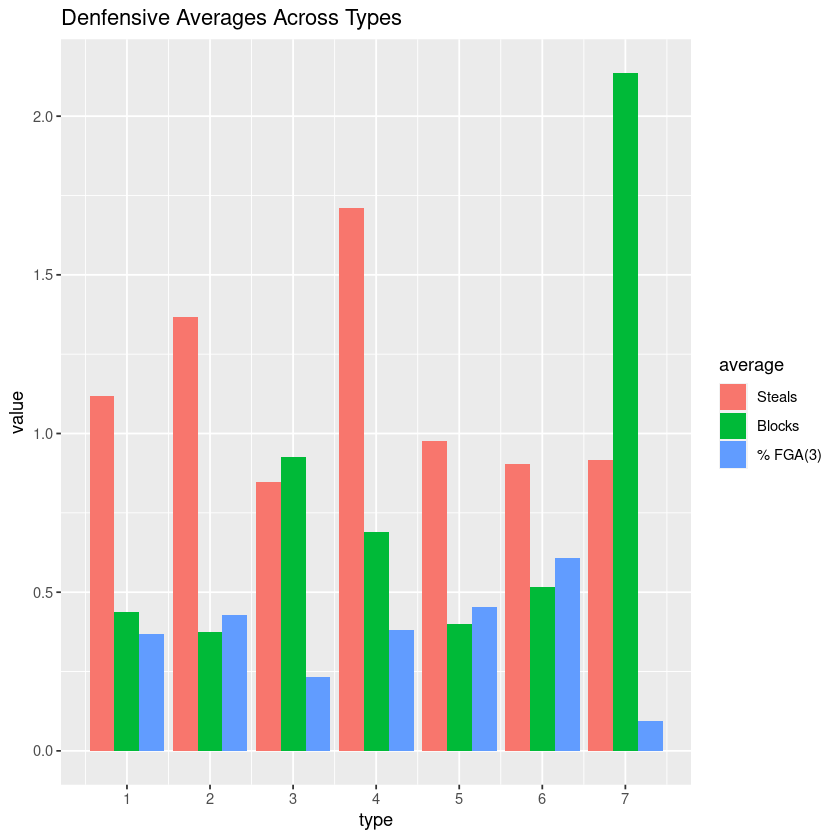

In [5]:

# creating average stats across types

main_avg <- mean_data %>%
  pivot_longer(cols=c('mean_points', 'mean_assists', 'mean_rebounds', 'mean_pa_ratio'),
               names_to = 'average')

main_avg$average <- factor(main_avg$average, levels = unique(main_avg$average))
main_avg$type <- as.integer(main_avg$type)


ggplot(main_avg,aes(x = type, y = value, fill = average)) +
geom_bar(stat = "identity", position = "dodge") +
  scale_x_continuous(breaks = 1:8) +
  scale_fill_discrete(labels=c('Points', 'Assists', 'Rebounds', 'PA Ratio')) +
  ggtitle("Offensive Averages Across Types")

secondary_avg <- mean_data %>%
  pivot_longer(cols=c('mean_steals', 'mean_blocks',
                      'mean_three_pct'),
               names_to = 'average')

secondary_avg$average <- factor(secondary_avg$average, levels = unique(secondary_avg$average))
secondary_avg$type <- as.integer(secondary_avg$type)

ggplot(secondary_avg, aes(x = type, y = value, fill = average)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_x_continuous(breaks = 1:8) +
  scale_fill_discrete(labels=c('Steals', 'Blocks', '% FGA(3)')) +
  ggtitle("Denfensive Averages Across Types")


Player Archetypes:

$*$ Note that the stats for all players are adjusted for playing time.

1. Elite All-around Players

Players in this cluster consists of all-star level caliber players. They possess exceptional abilities in scoring, play-making, and ultimately carrying their team to a win. On average, they score more, have more assists, and have higher usage rates than all other types of players. They also have the lowest $\%$ of field goals (two-pointers or three-pointers) assisted by teammates", meaning they have more isolation plays and are able to create their own shots. They are generally the best players on the court.

Notable Players: LeBron James, Luka Doncic, Stephen Curry, Kevin Durant, Giannis Antetokounmpo, and Shai-Gilgeous Alexander.

2. Distributors

Players in this cluster are mostly point guards. They are play-makers, pass-first point guards, or what we used to call traditional point guards. Their primary responsibility is to handle the rock and set up plays for teammates. Scoring is not heir number one priority, but making the right play is. They have the lowest PA Ratio (Points to Assist Ratio). They also have the second lowest "percentage of field goals assisted" behind type 1 players.

Notable Players: Mike Conley, Tyus Jones, Kyle Lowry, Ricky Rubio, Marcus Smart, and Killian Hayes.

3. Versatile Big Man

Not only can they grab rebounds, block shots, and dunk on people like traditional big men, they also have the ability to shoot the ball and make plays away from the rim. They are versatile in that, they do not necessarily have to be anchored to the paint; they can shoot mid-range shots and even three-pointers at good efficiency. On average, $23\%$ of their field goal attempts are three-pointers, much higher than that of a traditional big men, at $9\%$.

Notable Players: Joel Embiid, Karl-Anthony Towns, Lauri Markkanen, Christian Wood, and Kristaps Porzingis

* Note that Nikola Jokic should be in this category, but due to his one of a kind scoring and passing abilities, he is grouped in type 1

4. Defensive Specialists

Players in this cluster are lock-down defenders, usually guards and forwards. They excel in guarding multiple positions, disrupting plays and creating turnovers for the opposite team. They are tenacious players with a lot of hustle and heart. They have the third highest rebounding numbers behind traditional big men and versatile big men. They also have the highest number of steals per 36 min.

Notable Players: Jose Alvarado, Og Anunoby, Alex Caruso, Draymond Green, Herbert Jones, and Matisse Thybulle

5. High Volume Versatile Scorers

This cluster is comprised of players who exhibit exceptional scoring versatility. They are known for their capacity to score both inside and outside, utilizing a wide range of offensive skills, from three-point shooting to driving to the rim. They have the third highest scoring numbers behind Elite All-around Players and Versatile big men.

Notable Players: Mikal Bridges, Scottie Barnes, Kyle Kuzma, Tobias Harris, Andrew Wiggins, and Kelly Oubre Jr.

6. Sharpshooters

Players in this cluster can shoot the lights out. They sleep near the three-point line and play a crucial roles in spreading the defense and opening up opportunities for their teammates. Their sharpshooting skills make them valuable assets on the court, and they play a key role in their team's offensive strategy. 61 percent of their field goal attempts are from beyond the arc, which is the highest out of all player archetypes.

Notable Players: Luke Kennard, Duncan Robinson, Keegan Murray, Max Strus, Reggie Bullock, and Kevin Love.

7. Traditional Big Men

These players were there from the beginning of time. They are characterized by their imposing size, strength, and inside presence. These players excel in the low post, both on offense and defense, where they use their physicality to secure rebounds, protect the rim, and score in the paint. They have the highest rebounding and blocking numbers out of all player types.

Notable Players: Rudy Gobert, Andre Drummond, Steven Adams, Jarrett Allen, Mo Bamba, and DeAndre Jordan



